# Tree Regressions

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt

import sklearn
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model as lm
from sklearn import model_selection as ms
sklearn.set_config(print_changed_only=False)

import xgboost

import import_ipynb
from _Self_Written_Functions_Sheet import rmse

importing Jupyter notebook from _Self_Written_Functions_Sheet.ipynb


In [2]:
hp_full_strd = pd.read_csv('..\hp_3a_train_tree.csv', index_col=0)
hp_full_strd

,LotFrontage,LotArea,Street,Alley,Utilities,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtUnfSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolQC,Fence,MiscVal,NbMedianRank,TotalLivSF,BsmtFin,TotalPorchSF,YrsRemodToSold,Fireplace,Pool,MSSubClass_1-1/2 STORY FINISHED ALL AGES,MSSubClass_1-1/2 STORY PUD - ALL AGES,MSSubClass_1-STORY 1945 & OLDER,MSSubClass_1-STORY 1946 & NEWER ALL STYLES,MSSubClass_1-STORY PUD (Planned Unit Development) - 1946 & NEWER,MSSubClass_1-STORY W/FINISHED ATTIC ALL AGES,MSSubClass_2 FAMILY CONVERSION - ALL STYLES AND AGES,MSSubClass_2-1/2 STORY ALL AGES,MSSubClass_2-STORY 1945 & OLDER,MSSubClass_2-STORY 1946 & NEWER,MSSubClass_2-STORY PUD - 1946 & NEWER,MSSubClass_DUPLEX - ALL STYLES AND AGES,MSSubClass_PUD - MULTILEVEL - INCL SPLIT LEV/FOYER,MSSubClass_SPLIT FOYER,MSSubClass_SPLIT OR MULTI-LEVEL,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRA,Condition1_RRN,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRA,Condition2_RRN,BldgType_2fmCon,BldgType_Duplex,BldgType_TwnhsE,BldgType_TwnhsI,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_BrkComm,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CemntBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_WdShing,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.150685,0.033420,1.0,0.0,1.0,0.666667,0.500,0.949275,0.883333,0.122500,0.666667,0.50,0.8,0.75,0.25,1.000000,0.166667,0.064212,1.00,1.0,1.00,0.109641,0.413559,0.0,0.333333,0.0,0.50,0.5,0.375,0.333333,0.666667,0.461538,1.000000,0.996517,0.666667,0.4,0.368280,0.6,0.6,1.0,0.000000,0.082210,0.

In [3]:
hp_logsaleprice = pd.read_csv('..\hp_1a_no_imputation_logsaleprice.csv', index_col=0)
hp_logsaleprice

,SalePrice
0,12.247694
1,12.109011
2,12.317167
3,11.849398
4,12.429216
...,...
1453,12.072541
1454,12.254863
1455,12.493130
1456,11.864462


In [4]:
state = 0

# setting up train and test sets
xtrain, xtest, ytrain, ytest = ms.train_test_split(hp_full_strd,
                                                   hp_logsaleprice,
                                                   test_size=0.2,
                                                   random_state=state)

# Must flatten to fit
ytrain = ytrain.values.flatten()

# using standard kfold split
n_folds = ms.KFold(n_splits=5, random_state=state, shuffle=True)

# Tree Models

## Trying w RFR

In [5]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

rfr = RandomForestRegressor()

# parameters to use
# maxdepth = [10, 25, 50, 100, 250, 500]
# minsamlf = [1, 2, 3, 4, 5]
# minsamsplt = [2, 3, 4, 5]
# nestimators = [100, 250, 400, 500]
# oobscore = [True, False]
# warmstart = [True, False]
# 'max_depth': maxdepth,
#               'min_samples_leaf': minsamlf,
#               'min_samples_split': minsamsplt,
#               'n_estimators': nestimators,
#               'oob_score': oobscore,
#               'warm_start': warmstart

gparam_rfr = {}

# setting parameters
gs_rfr = ms.GridSearchCV(rfr, gparam_rfr, cv=n_folds, refit=True, n_jobs=-1,
                           scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_rfr.fit(xtrain, ytrain)

# setting up dataframe for results
train_scores.append(gs_rfr.best_estimator_.score(xtrain, ytrain))
test_scores.append(gs_rfr.best_estimator_.score(xtest, ytest))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_rfr, ytrain, xtrain))
test_rmse.append(rmse(gs_rfr, ytest, xtest))

# add the best parameters to the df
best_par_list.append(gs_rfr.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
rfr_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
rfr_res_df = pd.DataFrame(rfr_list_results).T
rfr_res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
rfr_res_df = pd.concat([rfr_res_df, best_par_df], axis=1, sort=False)

rfr_res_df

Wall time: 7.79 s


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE
0,0.982308,0.904235,0.05272,0.127396,-0.074676


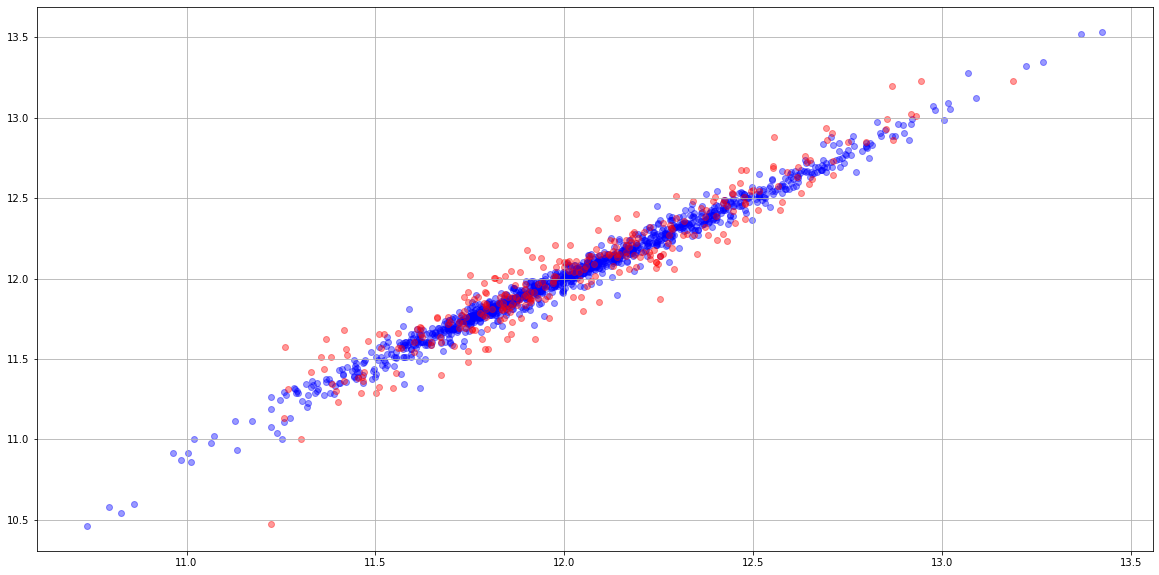

In [6]:
plt.figure(figsize=(20, 10))
plt.scatter(gs_rfr.best_estimator_.predict(xtrain), ytrain, color='blue', alpha=0.4)
plt.scatter(gs_rfr.best_estimator_.predict(xtest), ytest, color='red', alpha=0.4)
plt.grid(which='both')

In [7]:
sorted_importance_rfr = sorted(zip(hp_full_strd.columns,
                                   gs_rfr.best_estimator_.feature_importances_),
                               key=lambda t:t[1], reverse=True)
sorted_importance_rfr

[('OverallQual', 0.502793059835426),
 ('TotalLivSF', 0.24271700914410588),
 ('GarageArea', 0.02119086662416839),
 ('GarageCars', 0.01512267623730749),
 ('LotArea', 0.013780894871275554),
 ('1stFlrSF', 0.013096971915710832),
 ('NbMedianRank', 0.012184902417516635),
 ('BsmtUnfSF', 0.011583093029640057),
 ('YearBuilt', 0.011375720142250372),
 ('CentralAir', 0.011057435606438968),
 ('OverallCond', 0.010584832031127396),
 ('YrsRemodToSold', 0.01027634449968069),
 ('GarageYrBlt', 0.007251491667970021),
 ('YearRemodAdd', 0.006398559346349607),
 ('2ndFlrSF', 0.006033067208794502),
 ('LotFrontage', 0.005787414728313526),
 ('GarageType_Detchd', 0.005206643184291541),
 ('TotalPorchSF', 0.004409456627066049),
 ('MSZoning_RM', 0.00423542154328983),
 ('GarageCond', 0.004069876773928908),
 ('KitchenQual', 0.003824139287113418),
 ('OpenPorchSF', 0.003751652487660404),
 ('Fireplace', 0.0034462151819935937),
 ('WoodDeckSF', 0.0032080465401916605),
 ('ExterCond', 0.003189046692772123),
 ('BsmtQual', 0.00

In [8]:
filtered_sorted_importance_rfr = [x for x in sorted_importance_rfr if x[1]>0]
filtered_sorted_importance_rfr

[('OverallQual', 0.502793059835426),
 ('TotalLivSF', 0.24271700914410588),
 ('GarageArea', 0.02119086662416839),
 ('GarageCars', 0.01512267623730749),
 ('LotArea', 0.013780894871275554),
 ('1stFlrSF', 0.013096971915710832),
 ('NbMedianRank', 0.012184902417516635),
 ('BsmtUnfSF', 0.011583093029640057),
 ('YearBuilt', 0.011375720142250372),
 ('CentralAir', 0.011057435606438968),
 ('OverallCond', 0.010584832031127396),
 ('YrsRemodToSold', 0.01027634449968069),
 ('GarageYrBlt', 0.007251491667970021),
 ('YearRemodAdd', 0.006398559346349607),
 ('2ndFlrSF', 0.006033067208794502),
 ('LotFrontage', 0.005787414728313526),
 ('GarageType_Detchd', 0.005206643184291541),
 ('TotalPorchSF', 0.004409456627066049),
 ('MSZoning_RM', 0.00423542154328983),
 ('GarageCond', 0.004069876773928908),
 ('KitchenQual', 0.003824139287113418),
 ('OpenPorchSF', 0.003751652487660404),
 ('Fireplace', 0.0034462151819935937),
 ('WoodDeckSF', 0.0032080465401916605),
 ('ExterCond', 0.003189046692772123),
 ('BsmtQual', 0.00

## Trying w GBR

In [9]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

gbm = GradientBoostingRegressor()

# learningrate = [0.01, 0.05, 0.1, 0.5, 1] # subsequently, fine tune
# nestimators = [5, 10, 50, 100, 200, 300, 400, 500]
# maxfeatures = [9, 20, 40, 60, 100, 150, 176]
# maxdepth = [1, 2, 3, 4, 5]
# 'learning_rate': learningrate,
#               'n_estimators': nestimators, 
#               'max_features': maxfeatures,
#               'max_depth': maxdepth

gparam_gbm = {}

gs_gbm = GridSearchCV(gbm, gparam_gbm, cv=n_folds, refit=True, n_jobs=-1, 
                      scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_gbm.fit(xtrain, ytrain)

# setting up dataframe for results
train_scores.append(gs_gbm.best_estimator_.score(xtrain, ytrain))
test_scores.append(gs_gbm.best_estimator_.score(xtest, ytest))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_gbm, ytrain, xtrain))
test_rmse.append(rmse(gs_gbm, ytest, xtest))

# add the best parameters to the df
best_par_list.append(gs_gbm.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
gbm_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
gbm_res_df = pd.DataFrame(gbm_list_results).T
gbm_res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
gbm_res_df = pd.concat([gbm_res_df, best_par_df], axis=1, sort=False)

gbm_res_df

Wall time: 4.26 s


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE
0,0.95859,0.919943,0.080657,0.11648,-0.035823


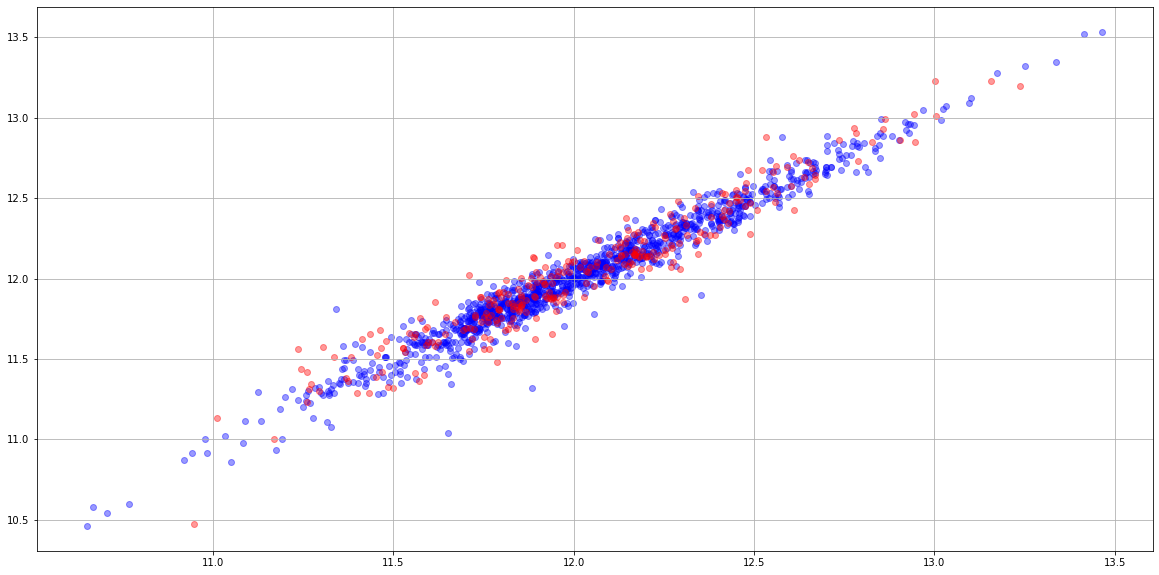

In [10]:
plt.figure(figsize=(20, 10))
plt.scatter(gs_gbm.best_estimator_.predict(xtrain), ytrain, color='blue', alpha=0.4)
plt.scatter(gs_gbm.best_estimator_.predict(xtest), ytest, color='red', alpha=0.4)
plt.grid(which='both')

In [11]:
sorted_importance_gbm = sorted(zip(hp_full_strd.columns,
                                   gs_gbm.best_estimator_.feature_importances_),
                               key=lambda t:t[1], reverse=True)
sorted_importance_gbm

[('OverallQual', 0.4117725407664408),
 ('TotalLivSF', 0.22123556367534675),
 ('KitchenQual', 0.06241288163238133),
 ('ExterQual', 0.026909962793268957),
 ('LotArea', 0.02395268328127429),
 ('1stFlrSF', 0.021743740049996314),
 ('GarageCars', 0.019827423059545747),
 ('YearBuilt', 0.018399745982760493),
 ('YrsRemodToSold', 0.016770089205156997),
 ('GarageArea', 0.015533307573891014),
 ('NbMedianRank', 0.014496605823305739),
 ('GarageFinish', 0.01379607465226453),
 ('CentralAir', 0.013729126932008518),
 ('BsmtQual', 0.013221648411184167),
 ('OverallCond', 0.012546903114481934),
 ('FireplaceQu_None', 0.008754933287843655),
 ('2ndFlrSF', 0.008435945397405345),
 ('Fireplace', 0.007709513115367596),
 ('BsmtUnfSF', 0.007216911161780638),
 ('GarageCond', 0.005364410998598577),
 ('GarageYrBlt', 0.005361626708019758),
 ('FullBath', 0.005080279464055704),
 ('TotRmsAbvGrd', 0.0048670049284253985),
 ('YearRemodAdd', 0.003736956120183908),
 ('Functional', 0.002754702728562746),
 ('MSZoning_RM', 0.0027

In [12]:
filtered_sorted_importance_gbm = [x for x in sorted_importance_gbm if x[1]>0]
filtered_sorted_importance_gbm

[('OverallQual', 0.4117725407664408),
 ('TotalLivSF', 0.22123556367534675),
 ('KitchenQual', 0.06241288163238133),
 ('ExterQual', 0.026909962793268957),
 ('LotArea', 0.02395268328127429),
 ('1stFlrSF', 0.021743740049996314),
 ('GarageCars', 0.019827423059545747),
 ('YearBuilt', 0.018399745982760493),
 ('YrsRemodToSold', 0.016770089205156997),
 ('GarageArea', 0.015533307573891014),
 ('NbMedianRank', 0.014496605823305739),
 ('GarageFinish', 0.01379607465226453),
 ('CentralAir', 0.013729126932008518),
 ('BsmtQual', 0.013221648411184167),
 ('OverallCond', 0.012546903114481934),
 ('FireplaceQu_None', 0.008754933287843655),
 ('2ndFlrSF', 0.008435945397405345),
 ('Fireplace', 0.007709513115367596),
 ('BsmtUnfSF', 0.007216911161780638),
 ('GarageCond', 0.005364410998598577),
 ('GarageYrBlt', 0.005361626708019758),
 ('FullBath', 0.005080279464055704),
 ('TotRmsAbvGrd', 0.0048670049284253985),
 ('YearRemodAdd', 0.003736956120183908),
 ('Functional', 0.002754702728562746),
 ('MSZoning_RM', 0.0027

In [13]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

xgb_t = xgboost.XGBRegressor()

# evalmetric = ['rmse']
# njobs = [-1]
# randomstate = [state]
# # booster_ = ['gbtree']

# nestimators = [1, 10, 20, 50, 100]
# minchildweight = [1, 3, 5]
# maxdepth = [1, 3, 5]
# learningrate = [0.01, 0.05, 0.1]
# gamma_ = [0.5, 1, 2, 5]
# subsample_ = [0.8, 1]
# # samplingmethod = ['uniform', 'gradient_based']
# colsamplebytree = [0.8, 1]
# lambda_ = [1, 3, 5]
# alpha_ = [1, 3, 5]
# 'eval_metric': evalmetric,
#                 'n_jobs': njobs,
# #                 'booster': booster_,
#                 'n_estimators': nestimators,
#                 'min_child_weight': minchildweight,
#                 'max_depth': maxdepth,
#                 'eta': learningrate,
#                 'gamma': gamma_,
#                 'subsample': subsample_,
# #                 'sampling_method': samplingmethod,
#                 'colsample_bytree': colsamplebytree,
#                 'lambda': lambda_,
#                 'alpha': alpha_,
#                 'random_state': randomstate


gparam_xgb_t = {}

gs_xgb_t = GridSearchCV(xgb_t, gparam_xgb_t, cv=n_folds, refit=True, verbose=1,
                      scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_xgb_t.fit(xtrain, ytrain)

# setting up dataframe for results
train_scores.append(gs_xgb_t.best_estimator_.score(xtrain, ytrain))
test_scores.append(gs_xgb_t.best_estimator_.score(xtest, ytest))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_xgb_t, ytrain, xtrain))
test_rmse.append(rmse(gs_xgb_t, ytest, xtest))

# add the best parameters to the df
best_par_list.append(gs_xgb_t.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
xgb_t_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
xgb_t_res_df = pd.DataFrame(xgb_t_list_results).T
xgb_t_res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
xgb_t_res_df = pd.concat([xgb_t_res_df, best_par_df], axis=1, sort=False)

xgb_t_res_df

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Wall time: 51.3 s


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE
0,0.999574,0.909707,0.008177,0.123703,-0.115525


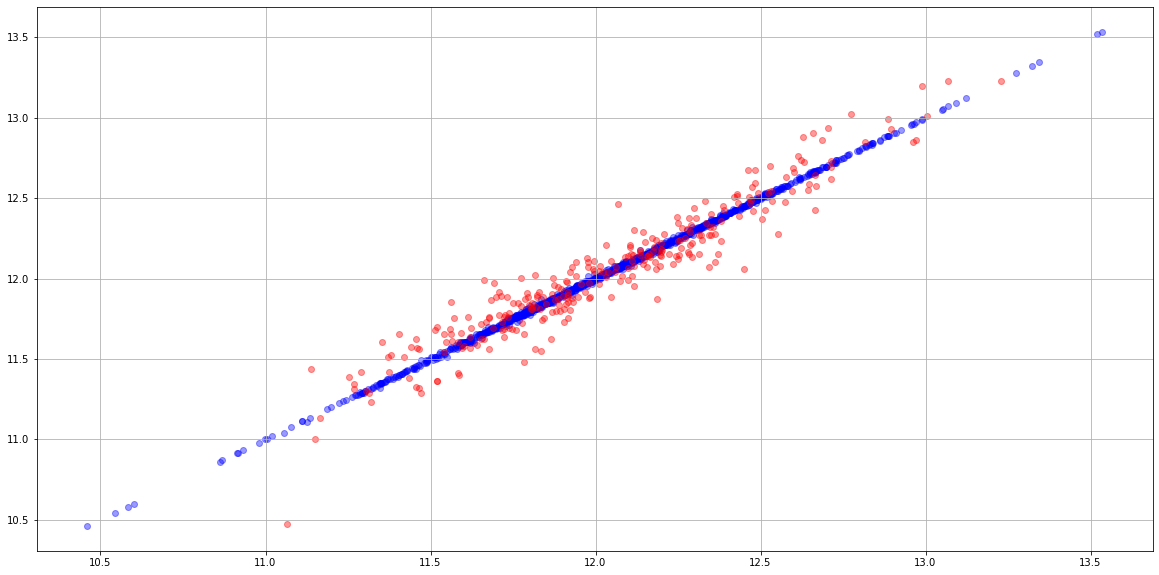

In [14]:
plt.figure(figsize=(20, 10))
plt.scatter(gs_xgb_t.best_estimator_.predict(xtrain), ytrain, color='blue', alpha=0.4)
plt.scatter(gs_xgb_t.best_estimator_.predict(xtest), ytest, color='red', alpha=0.4)
plt.grid(which='both')

In [15]:
sorted_importance_xgb_t = sorted(zip(hp_full_strd.columns,
                                   gs_xgb_t.best_estimator_.feature_importances_),
                               key=lambda t:t[1], reverse=True)
sorted_importance_xgb_t

[('GarageCars', 0.28301123),
 ('KitchenQual', 0.1111339),
 ('OverallQual', 0.07624553),
 ('SaleCondition_Partial', 0.045579046),
 ('Fireplace', 0.043871865),
 ('TotalLivSF', 0.039632015),
 ('CentralAir', 0.023407785),
 ('GarageType_CarPort', 0.019229013),
 ('Exterior1st_BrkFace', 0.017004697),
 ('RoofMatl_WdShake', 0.01575581),
 ('KitchenAbvGr', 0.015222709),
 ('GarageType_Basment', 0.014445298),
 ('SaleType_ConLD', 0.013434397),
 ('Functional', 0.012757131),
 ('FullBath', 0.010770449),
 ('NbMedianRank', 0.010537582),
 ('MSZoning_RL', 0.00967445),
 ('Condition1_Norm', 0.008462217),
 ('Neighborhood_Gilbert', 0.0075821397),
 ('SaleCondition_Family', 0.006776928),
 ('Exterior1st_Plywood', 0.0066942926),
 ('SaleType_New', 0.006530378),
 ('YearBuilt', 0.006390199),
 ('HouseStyle_1Story', 0.006012072),
 ('Heating_GasA', 0.0059184968),
 ('OverallCond', 0.0057472647),
 ('ScreenPorch', 0.00538116),
 ('LotArea', 0.0052317916),
 ('Neighborhood_Somerst', 0.0051032556),
 ('Neighborhood_NAmes', 0.00

In [16]:
filtered_sorted_importance_xgb_t = [x for x in sorted_importance_xgb_t if x[1]>0]
filtered_sorted_importance_xgb_t

[('GarageCars', 0.28301123),
 ('KitchenQual', 0.1111339),
 ('OverallQual', 0.07624553),
 ('SaleCondition_Partial', 0.045579046),
 ('Fireplace', 0.043871865),
 ('TotalLivSF', 0.039632015),
 ('CentralAir', 0.023407785),
 ('GarageType_CarPort', 0.019229013),
 ('Exterior1st_BrkFace', 0.017004697),
 ('RoofMatl_WdShake', 0.01575581),
 ('KitchenAbvGr', 0.015222709),
 ('GarageType_Basment', 0.014445298),
 ('SaleType_ConLD', 0.013434397),
 ('Functional', 0.012757131),
 ('FullBath', 0.010770449),
 ('NbMedianRank', 0.010537582),
 ('MSZoning_RL', 0.00967445),
 ('Condition1_Norm', 0.008462217),
 ('Neighborhood_Gilbert', 0.0075821397),
 ('SaleCondition_Family', 0.006776928),
 ('Exterior1st_Plywood', 0.0066942926),
 ('SaleType_New', 0.006530378),
 ('YearBuilt', 0.006390199),
 ('HouseStyle_1Story', 0.006012072),
 ('Heating_GasA', 0.0059184968),
 ('OverallCond', 0.0057472647),
 ('ScreenPorch', 0.00538116),
 ('LotArea', 0.0052317916),
 ('Neighborhood_Somerst', 0.0051032556),
 ('Neighborhood_NAmes', 0.00